# For educational or discussion purposes لغرض تعليمي او تناقش

In [ ]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os



In [ ]:
# for Kaggle 
```
train_loc = '/kaggle/input/covidctscanaugmented/dataset/'
test_loc = '/kaggle/input/covidctscanaugmented/dataset/'
val_loc = "/kaggle/input/covidctscanaugmented/dataset/"
```
# local
```
train_loc = 'dataset/'
test_loc = 'dataset/'
val_loc = "dataset/"
```

In [ ]:

INIT_LR = 0.0003
EPOCHS = 5
Batch_size = 32

train_loc = 'dataset/'
test_loc = 'dataset/'
val_loc = "dataset/"

# resize images & Data Agumention
trdata = ImageDataGenerator(rescale=1./255, shear_range=0.2,
                            zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")
traindata = trdata.flow_from_directory(
    directory=train_loc, target_size=(96, 96), shuffle=True)
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory(
    directory=test_loc, target_size=(96, 96), shuffle=False)
vdata = ImageDataGenerator(rescale=1./255)
valdata = vdata.flow_from_directory(
    directory=val_loc, target_size=(96, 96), shuffle=True)

traindata.class_indices

In [3]:
input_shape = (96, 96, 3)
img_input = Input(shape=input_shape, name='img_input')

# Build the model
x = Conv2D(32, (3, 3), padding='same',
           activation='relu', name='layer_1')(img_input)
x = Conv2D(64, (3, 3), padding='same', activation='relu', name='layer_2')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='layer_3')(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu', name='layer_4')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='layer_5')(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', name='layer_6')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='layer_7')(x)
x = Dropout(0.25)(x)

x = Flatten(name='layer_8')(x)
x = Dense(64, name='layer_9')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='predections')(x)

# generate the model
model = Model(inputs=img_input, outputs=x, name='CNN-Covid-ct-scan')

# pint network structure
model.summary()

Model: "CNN-Covid-ct-scan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 96, 96, 3)]       0         
                                                                 
 layer_1 (Conv2D)            (None, 96, 96, 32)        896       
                                                                 
 layer_2 (Conv2D)            (None, 96, 96, 64)        18496     
                                                                 
 layer_3 (MaxPooling2D)      (None, 48, 48, 64)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 layer_4 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 layer_5 (MaxPooling2D)      (None, 24, 24, 64)  

In [4]:
# compile our model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

my_callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=0, mode="auto")]

# train the head of the network
print("[INFO] training head...")
hist = model.fit(
    traindata, batch_size=Batch_size,
    steps_per_epoch=traindata.samples // Batch_size,
    validation_steps=valdata.samples // Batch_size,
    callbacks=my_callbacks,
    epochs=EPOCHS,
    validation_data=valdata
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/5
1306/1306 [==============================] - 1385s 1s/step - loss: 0.5701 - accuracy: 0.6989 - val_loss: 0.4629 - val_accuracy: 0.7761
Epoch 2/5
1306/1306 [==============================] - 824s 630ms/step - loss: 0.4317 - accuracy: 0.8004 - val_loss: 0.4230 - val_accuracy: 0.8005
Epoch 3/5
1306/1306 [==============================] - 815s 624ms/step - loss: 0.3303 - accuracy: 0.8543 - val_loss: 0.3184 - val_accuracy: 0.8536
Epoch 4/5
1306/1306 [==============================] - 769s 589ms/step - loss: 0.2543 - accuracy: 0.8931 - val_loss: 0.2342 - val_accuracy: 0.8924
Epoch 5/5
1306/1306 [==============================] - 739s 566ms/step - loss: 0.1933 - accuracy: 0.9235 - val_loss: 0.2708 - val_accuracy: 0.8881


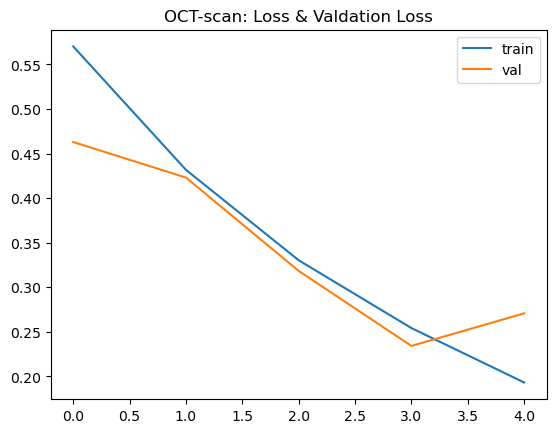

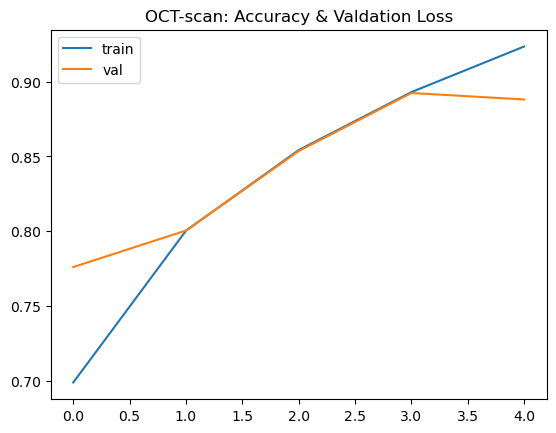

1307/1307 [==============================] - 156s 119ms/step
Confusion Matrix
[[20640   300]
 [ 4380 16500]]
Classification_report


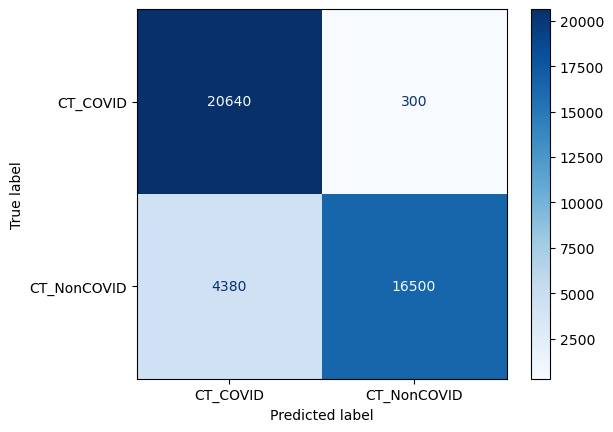

[[20640   300]
 [ 4380 16500]]
acc: 0.8881
sensitivity: 0.9857
specificity: 0.7902


In [5]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('OCT-scan: Loss & Valdation Loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('OCT-scan: Accuracy & Valdation Loss')
plt.legend()
plt.show()

# Confusion Matrix & Precision & recall F1-score

target_names = ["CT_COVID","CT_NonCOVID"]
labels_names =[0,1]

Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred, labels=labels_names)

print('Confusion Matrix')
print(confusion_matrix(testdata.classes, y_pred))

print('Classification_report')
#print(classification_report(testdata.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')

plt.show()

total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

#model.save('oct_scratch_lite.h5', save_format="h5")


In [6]:
model.save('covid-ct-scan.h5', save_format="h5")